In [1]:
import os
os.chdir("..")
import sys
sys.path.append(os.getcwd())
print(os.getcwd())

/home/development/SPOT/backend-zoning


In [10]:
# third party imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jeffutils.analytics import set_np_pd_display_params
set_np_pd_display_params(np, pd)

# load all of the results for a specific model_label

In [3]:
model_label = "256hist_center_kandzerocenters"
model_label = "8hist_center_kandzerocenters"
model_directory = f"tests/results/{model_label}/"
dfs = []
for directory in os.listdir(model_directory):
    zoneID = directory
    directory = os.path.join(model_directory, directory)
    df = pd.concat([
        pd.read_csv(os.path.join(directory, f))
        for f in os.listdir(directory)
        if f.endswith(".csv")
    ]).reset_index(drop=True)
    df["zoneID"] = zoneID
    dfs.append(df)
full_results_df = pd.concat(dfs).reset_index(drop=True)

# load and display the accuracy tables

In [4]:
def get_accuracy_table(cols:list[str]|str):
    acc_tab = (full_results_df
        .groupby(by=cols)
        ['is_match']
        .mean()
        .reset_index()
        .sort_values(by='is_match', ascending=False).
        rename(columns={'is_match': 'accuracy'}))
    return acc_tab

full_accuracy_table = get_accuracy_table(['zoneID', 'zone_size', 'k', 'pair_index'])
zoneID_accuracy_table = get_accuracy_table('zoneID')
zone_size_accuracy_table = get_accuracy_table('zone_size')
pair_index_accuracy_table = get_accuracy_table('pair_index')

zone_size_accuracy_table['random_acc'] = 1/zone_size_accuracy_table['zone_size']
zone_size_accuracy_table['better_than_random'] = zone_size_accuracy_table['accuracy'] > zone_size_accuracy_table['random_acc']
zone_size_accuracy_table['perc_better_than_random'] = (zone_size_accuracy_table['accuracy'] - zone_size_accuracy_table['random_acc']) / zone_size_accuracy_table['random_acc'] * 100
zone_size_accuracy_table['timesX_better_than_random'] = zone_size_accuracy_table['accuracy'] / zone_size_accuracy_table['random_acc']

display(full_accuracy_table)
display(zoneID_accuracy_table)
display(pair_index_accuracy_table)
display(zone_size_accuracy_table)

,zoneID,zone_size,k,pair_index,accuracy
140,JFSBP1_center_east-region_1-south_east,11,5,4,1.0000000
156,JFSBP1_center_east-region_1-south_east,11,7,4,1.0000000
69,JFSBP1_center_east-region_1-south_east,9,3,5,1.0000000
68,JFSBP1_center_east-region_1-south_east,9,3,4,1.0000000
164,JFSBP1_center_east-region_1-south_east,11,8,4,1.0000000
...,...,...,...,...,...
65,JFSBP1_center_east-region_1-south_east,9,3,1,0.0000000
170,JFSBP1_center_east-region_1-south_east,11,9,2,0.0000000
63,JFSBP1_center_east-region_1-south_east,7,7,7,0.0000000
174,JFSBP1_center_east-region_1-south_east,11,9,6,0.0000000


,zoneID,accuracy
0,JFSBP1_center_east-region_1-south_east,0.3565670


,pair_index,accuracy
5,5,1.0000000
4,4,0.7707432
3,3,0.6067637
1,1,0.3456547
0,0,0.1108926
2,2,0.0157295
7,7,0.0015729
6,6,0.0011797


,zone_size,accuracy,random_acc,better_than_random,perc_better_than_random,timesX_better_than_random
0,5,0.4433333,0.2000000,True,121.6666667,2.2166667
1,7,0.3815000,0.1428571,True,167.0500000,2.6705000
2,9,0.3487500,0.1111111,True,213.8750000,3.1387500
3,11,0.3262500,0.0909091,True,258.8750000,3.5887500
4,13,0.3164336,0.0769231,True,311.3636364,4.1136364


# display correlation and overall accuracy

In [9]:
zone_size_corr = full_accuracy_table['zone_size'].corr(full_accuracy_table['accuracy'])
print(f"Pearson correlation coefficient between 'zone_size' and 'accuracy': {zone_size_corr}")
k_corr = full_accuracy_table['k'].corr(full_accuracy_table['accuracy'])
print(f"Pearson correlation coefficient between 'k' and 'accuracy': {k_corr}")
overall_accuracy = full_results_df['is_match'].mean()
print(f"Overall accuracy: {overall_accuracy}")

Pearson correlation coefficient between 'zone_size' and 'accuracy': -0.07897021443042365
Pearson correlation coefficient between 'k' and 'accuracy': 0.06813149214183732
Overall accuracy: 0.35656704679512385


# display the spread of accuracies

count   294.0000000
mean      0.3462297
std       0.4366913
min       0.0000000
0%        0.0000000
25%       0.0000000
50%       0.0250000
75%       0.9975000
100%      1.0000000
max       1.0000000
dtype: float64

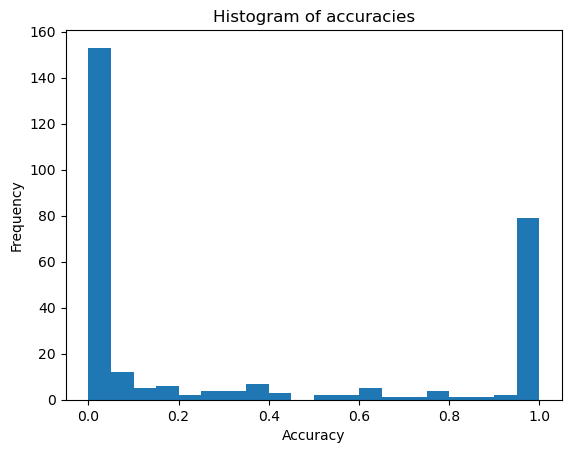

In [8]:
accuracies = np.concatenate([
    full_accuracy_table['accuracy'].values,
    zoneID_accuracy_table['accuracy'].values,
    pair_index_accuracy_table['accuracy'].values,
    zone_size_accuracy_table['accuracy'].values,
])
display(pd.Series(accuracies).describe(percentiles=[0.0, 0.25, 0.5, 0.75, 1.0]))

plt.hist(accuracies, bins=20)
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.title("Histogram of accuracies")
plt.show()

# notes

It appears that the accuracy is either 0 for all tests or 1.0 for all tests, so there must be a situation in the data that is causing this. Some of the enter/leave pairs just work and some don't

**Changes analysis:**
  * I changed the closest_k_points to always include the points that have a center of (0, 0) since this is what is returned by the get_center_pt function if the car didn't actually fully cross into the zone. This change increased the accuracy from ~18% to 35%
  * I changed the Histogram bin size to 8, and the accuracy stayed at 35%, but the zone_size and k correlation dropped to having NO correlation at all, which is a VERY big win